# Object Detection using Sliding Window and NMS


* Detect bounding boxes using resnet 18, correct data loading and preprocessing. Plot any 5 correct and 5 incorrect sample detections from the test set in this notebook for both the approached (1 layer and 2 layer detection), so total of 20 plots.


* Use two layers (multi-scale feature maps) to detect objects independently as in SSD (https://arxiv.org/abs/1512.02325).  In this method, 1st detection will be through the last layer of Resnet18 and the 2nd detection could be through any layer before the last layer. SSD uses lower resolution layers to detect larger scale objects. 


* Implement Non-maximum suppression (NMS) (should not be imported from any library) on the candidate bounding boxes.

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
import xml.etree.ElementTree as ET
from PIL import Image
from shutil import copyfile
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import shutil

%matplotlib inline
plt.ion()

resnet_input = 224 #size of resnet18 input images

In [2]:
# Choose your hyper-parameters using validation data
batch_size = 64
epochs = 3
learning_rate =  0.005
hyp_momentum = 0.9

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, i.e. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the three classes(aeroplane, bottle, chair). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be four. This is important for applying the sliding window method later.


In [3]:
classes = ('__background__',
           'aeroplane',
           'bottle','chair'
           )

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
k = 0
def intersection_over_union(orig_boxes,bg_boxes,img,file,count):
    global k
    for bg_box in bg_boxes:
        flag = 0
        for orig_box in orig_boxes:
            boxA = orig_box
            boxB = bg_box
            xA = max(boxA[0], boxB[0])
            yA = max(boxA[1], boxB[1])
            xB = min(boxA[2], boxB[2])
            yB = min(boxA[3], boxB[3])
 
            # compute the area of intersection rectangle
            interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
            # compute the area of both the prediction and ground-truth
            # rectangles
            boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
            boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
            # compute the intersection over union by taking the intersection
            # area and dividing it by the sum of prediction + ground-truth
            # areas - the interesection area
            iou = float(interArea) / float(boxAArea + boxBArea - interArea)
            if iou > 0.4:
                flag=1
                break
#             if interArea==0 and k<700:
        if not flag and count%4 == 0:
            cropped_img = img.crop(bg_box)
            new_image_path = "data2/processed_data/{}/{}_{}".format('__background__', str(k), file.split('.')[0] + ".jpg")
            cropped_img.save(new_image_path)
            k+=1

In [6]:
def build_dataset():
    c=0
    found_classes = {'__background__': 0}
    processed_dir = 'data2/processed_data'
    if os.path.exists(processed_dir):
        shutil.rmtree(processed_dir)
    os.makedirs(processed_dir)
    data_path = "data2/VOCdevkit/Annotations/"
    images_path = "data2/VOCdevkit/JPEGImages/"
    for i in classes:
        directory = "data2/processed_data/{}".format(i)
        if not os.path.exists(directory):
            os.makedirs(directory)
    count = 0
    for file in os.listdir(data_path):
        flag = 0
        f = open(data_path + file, "r").read()
        xml = ET.fromstring(f)
        objects = xml.findall('./object')
        boxes = []
        for obj in objects:
            img_class = obj.find('name').text
            if img_class in classes:
                c+=1
                if found_classes.get(img_class, None) is not None:
                    found_classes[img_class] += 1
                else:
                    found_classes[img_class] = 1
                box = obj.find('bndbox')
                xmin = int(box.find('xmin').text)
                ymin = int(box.find('ymin').text)
                ymax = int(box.find('ymax').text)
                xmax = int(box.find('xmax').text)
                image_path = images_path + file.split('.')[0] + ".jpg"
                img = Image.open(image_path)
                area = (xmin, ymin, xmax, ymax)
                cropped_img = img.crop(area)
                new_image_path = "data2/processed_data/{}/{}_{}".format(img_class, str(c), file.split('.')[0] + ".jpg")
                cropped_img.save(new_image_path)
                flag = 1
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            xmax = int(box.find('xmax').text)
            coordinates = [xmin, ymin, xmax, ymax]
            boxes.append(coordinates)
        image_path = images_path + file.split('.')[0] + ".jpg"
        img = Image.open(image_path)
        width, height = img.size
        if width<224 or height<224:
            continue
        bg = []
#         coordinates = [0,0,224,224]
#         bg.append(coordinates)
#         coordinates = [width-224,0,width,224]
#         bg.append(coordinates)
#         coordinates = [0,height-224,224,height]
#         bg.append(coordinates)
#         coordinates = [width-224,height-224,width,height]
#         bg.append(coordinates)
        coordinates = [0,0,100,100]
        bg.append(coordinates)
        coordinates = [width-100,0,width,100]
        bg.append(coordinates)
        coordinates = [0,height-100,100,height]
        bg.append(coordinates)
        coordinates = [width-100,height-100,width,height]
        bg.append(coordinates)
        coordinates = [int(width/2)-20,height-70,int(width/2)+20,height]
        bg.append(coordinates)
        coordinates = [int(width/2)-20,0,int(width/2)+20,70]
        bg.append(coordinates)
        coordinates = [0,int(height/2)-20,70,int(height/2)+20]
        bg.append(coordinates)
        coordinates = [0,int(height/2)-20,70,int(height/2)+20]
        bg.append(coordinates)
        coordinates = [width-70,int(height/2)-20,width,int(height/2)+20]
        bg.append(coordinates)
        intersection_over_union(boxes,bg,img,file,count)
        count+=1
    found_classes['__background__'] = k
    print(found_classes)

In [7]:
# build_dataset()

In [8]:
data_dir = 'data2/processed_data/'
def load_split_train_test(datadir, valid_size = .05):
    train_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    print(num_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .1)
print(trainloader.dataset.classes)

13436
['__background__', 'aeroplane', 'bottle', 'chair']


## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 4 classes of the VOC dataset. 

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
# model = models.vgg16(pretrained=True)
model = models.resnet18(pretrained=True)
                                 
for param in model.parameters():
    param.requires_grad = False

# model.classifier = nn.Sequential(nn.Linear(25088, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 5),
#                                  nn.LogSoftmax(dim=1))
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 2048),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                        nn.Linear(2048, 512),
                        nn.ReLU(),
                         nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1)
)

# model.classifier = nn.Sequential(nn.Linear(25088, 4),
#                                  nn.LogSoftmax(dim=1))
# Add code for using CUDA here

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
# Update if any errors occur
# optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)

In [ ]:
#One Layer Detection
def train():
#     epochs = 3
    steps = 0
    running_loss = 0
    print_every = 20
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss : {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                acc = accuracy/len(testloader)
#                 if acc >= 0.99:
#                     torch.save(model, 'models/resnet18.pth')
                running_loss = 0
                model.train()
#     torch.save(model, 'models/resnet18.pth')

In [9]:
model = torch.load('models/resnet18.pth')

In [ ]:
%time train()

In [ ]:
# torch.save(model, 'models/resnet18.pth')

### 2 Layer model training

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
modelA = models.vgg16(pretrained=True)
# modelA = models.resnet18(pretrained=True)
                                 
for param in modelA.parameters():
    param.requires_grad = False

modelA = nn.Sequential(*list(modelA.features.children()))
# count = -1
# x = []
# for i in modelA.children():
#     count+=1
#     if(count == 9):
#         continue
#     x.append(i)
# modelA = nn.Sequential(*x)
modelA.to(device)

modelB = models.vgg16(pretrained=True)
# modelB = models.resnet18(pretrained=True)
for param in modelB.parameters():
    param.requires_grad = False

x = []
count = -1
for i in modelB.features.children():
    count+=1
    
    if count >= 24:
        break
    if(count == 23):
        x.append(nn.MaxPool3d(2, stride=3, padding=0, dilation=1, return_indices=False, ceil_mode=False))
        continue
    x.append(i)

# x = []
# count = -1
# for i in modelB.children():
#     count+=1
#     if(count == 7 or count == 9):
#         continue
#     x.append(i)

new_features = nn.Sequential(*x)
modelB = new_features
modelB.to(device)
# print(modelB)

modelC = nn.Sequential(nn.Linear(38939, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))

# modelC = nn.Sequential(nn.Linear(16896, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 4),
#                                  nn.LogSoftmax(dim=1))

In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
# Update if any errors occur
# optimizer = optim.SGD(model.parameters(), learning_rate, hyp_momentum)
optimizer = optim.Adam(modelC.parameters(), lr=learning_rate)
modelC.to(device)

In [ ]:
#Two Layer Detection (SSD)
def train2():
    epochs = 3
    steps = 0
    running_loss = 0
    print_every = 20
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device),labels.to(device)
            optimizer.zero_grad()
#             print(inputs.shape)
            outputA = modelA.forward(inputs)
            outputB = modelB.forward(inputs)
#             print(outputA.shape, outputB.shape)
#             outputA = outputA.resize_((outputA.shape[0], 25088))
#             outputB = outputB.resize_((outputB.shape[0], 13851))
        
            outputA = outputA.resize_((outputA.shape[0], 512))
            outputB = outputB.resize_((outputB.shape[0], 16384))
            
            outputC = torch.cat((outputA, outputB), dim=1)
#             print(outputC.shape)
            logps = modelC.forward(outputC)
#             print(logps.shape)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
      
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                modelC.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputA = modelA.forward(inputs)
                        outputB = modelB.forward(inputs)
           #             print(outputA.shape, outputB.shape)
            #             outputA = outputA.resize_((outputA.shape[0], 25088))
            #             outputB = outputB.resize_((outputB.shape[0], 13851))

                        outputA = outputA.resize_((outputA.shape[0], 512))
                        outputB = outputB.resize_((outputB.shape[0], 16384))
                    
                        outputC = torch.cat((outputA, outputB), dim=1)
                        logps = modelC.forward(outputC)
                        batch_loss = criterion(logps, labels)
                        test_loss += batch_loss.item()
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))                    
                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss : {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(testloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(testloader):.3f}")
                acc = accuracy/len(testloader)
#                 if acc >= 0.99:
#                     torch.save(modelC, 'models/resnet18_2.pth')
                running_loss = 0
                modelC.train()
#     torch.save(modelC, 'models/resnet18_2.pth')

In [ ]:
%time train2()

In [ ]:
# torch.save(modelC, 'models/resnet18_2.pth')

In [38]:
modelC = torch.load('models/resnet18_2.pth')

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [12]:
def sliding_window(image, windowSize, stepSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
                yield (x, y, image[y:y + windowSize[0], x:x + windowSize[1]])

In [13]:
# image = Image.open("data2/000260.jpg")
# image

In [14]:
# image = np.array(Image.open("data2/000260.jpg"))
# image = image[0:70, 0:40]
# im = Image.fromarray(image)
# im

In [40]:
test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                      transforms.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predict_image2(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inputa = Variable(image_tensor)
    inputa = inputa.to(device)
    outputA = modelA.forward(inputa)
    outputB = modelB.forward(inputa)
#     print(outputA.shape, outputB.shape)
    outputA = outputA.resize_((outputA.shape[0], 25088))
    outputB = outputB.resize_((outputB.shape[0], 13851))
    
#     outputA = outputA.resize_((outputA.shape[0], 512))
#     outputB = outputB.resize_((outputB.shape[0], 16384))
    
    outputC = torch.cat((outputA, outputB), dim=1)
    output = model(outputC)
    output = torch.exp(output)
    return output

def predict_image(image, model):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inputa = Variable(image_tensor)
    inputa = inputa.to(device)
    output = model(inputa)
    output = torch.exp(output)
    return output

In [31]:
def test_image(image_path, model):
#     x = Image.open('data/VOCdevkit/JPEGImages/002847.jpg')
    x = Image.open(image_path)
    test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                          transforms.ToTensor(), transforms.ToPILImage(mode=None)])
    image = test_transforms(x)
    np_image = np.array(image)
#     windowSize = [(40, 70), (70, 40), (40, 40), (100, 150), (150, 100),
#                   (100, 100), (150, 200), (200, 150), (150, 150)]
    windowSize = [(100,100),(40, 70), (70, 40), (100, 150)]
    z = []
    for i in windowSize:
        for (x, y, window) in sliding_window(np_image, i, 10):
            if window.shape[0] != i[0] or window.shape[1] != i[1]:
                continue
            else:
                xa = x
                ya = y
                xb = x + i[1]
                yb = y + i[0]
                im = Image.fromarray(window)
                z.append((im, (xa, ya, xb, yb)))
#     print("Total predictions ", len(z))
    boxes = []
    for img in z:
#         image = Image.open(i)
        output = predict_image(img[0], model)
        score = output.data.cpu().numpy().max()
        index = output.data.cpu().numpy().argmax()
#         score = output[index]
        cl = classes[index]
        boxes.append((img[1], cl, score))
#         if img[1]==(133, 0, 203, 40):
#             print(cl,score)
    return boxes

In [32]:
def test_image2(image_path, model):
#     x = Image.open('data/VOCdevkit/JPEGImages/002847.jpg')
    x = Image.open(image_path)
    test_transforms = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                          transforms.ToTensor(), transforms.ToPILImage(mode=None)])
    image = test_transforms(x)
    np_image = np.array(image)
    windowSize = [(40, 70), (70, 40), (40, 40), (100, 150), (150, 100),
                  (100, 100), (180, 200), (200, 180), (180, 180)]
#     windowSize = [(100,100),(40, 70), (70, 40), (100, 150)]
    z = []
    for i in windowSize:
        for (x, y, window) in sliding_window(np_image, i, 10):
            if window.shape[0] != i[0] or window.shape[1] != i[1]:
                continue
            else:
                xa = x
                ya = y
                xb = x + i[1]
                yb = y + i[0]
                im = Image.fromarray(window)
                z.append((im, (xa, ya, xb, yb)))
#     print("Total predictions ", len(z))
    boxes = []
    for img in z:
#         image = Image.open(i)
        output = predict_image2(img[0], model)
        score = output.data.cpu().numpy().max()
        index = output.data.cpu().numpy().argmax()
#         score = output[index]
        cl = classes[index]
        boxes.append((img[1], cl, score))
#         if img[1]==(133, 0, 203, 40):
#             print(cl,score)
    return boxes

In [33]:
def iou(boxA,boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou_ = float(interArea) / float(boxAArea + boxBArea - interArea)
    return iou_

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [34]:
def non_maximum_supression(boxes,threshold = 0.3):
#     print("Starting non max supression..")
    
    c = {}
    for i in boxes:
        if i[1] in c:
            c[i[1]] +=1
        else:
            c[i[1]] = 1

    my_class = None
    count = -1
    for i, j in c.items():
        if j > count and i != "__background__":
            my_class = i
            count = j
    new_boxes = []
    for i in boxes:
        if i[1] == my_class:
            new_boxes.append(i)
    boxes = new_boxes
    bounding_box = []
    count=0
    count2 = 0
    flag = [0]*len(boxes)
    while(count<len(boxes)):
        max_score = -99999999
        best_box = []
        for i,box1 in enumerate(boxes):
            for j,box2 in enumerate(boxes):
                if (flag[i]==0 or flag[j]==0) and iou(box1[0],box2[0])>threshold:
                    if flag[i] == 0:
                        count += 1
                    if flag[j] == 0:
                        count += 1
                    flag[i] = 1
                    flag[j] = 1
                    if max_score<max(box1[2],box2[2]):
                        max_score = max(box1[2],box2[2])
                        if box1[2]>box2[2]:
                            best_box = box1
                        elif box1[2]<box2[2]:
                            best_box = box2
                        else:
                            area_box1 = (box1[0][2] - box1[0][0] + 1) * (box1[0][3] - box1[0][1] + 1)
                            area_box2 = (box2[0][2] - box2[0][0] + 1) * (box2[0][3] - box2[0][1] + 1)
                            if area_box1>area_box2:
                                best_box = box1
                            else:
                                best_box = box2
                    elif max_score==box1[2]:
                        area_box1 = (box1[0][2] - box1[0][0] + 1) * (box1[0][3] - box1[0][1] + 1)
                        area_best_box = (best_box[0][2] - best_box[0][0] + 1) * (best_box[0][3] - best_box[0][1] + 1)
                        if area_box1>area_best_box:
                                best_box = box1
                    elif max_score==box2[2]:
                        area_box2 = (box2[0][2] - box2[0][0] + 1) * (box2[0][3] - box2[0][1] + 1)
                        area_best_box = (best_box[0][2] - best_box[0][0] + 1) * (best_box[0][3] - best_box[0][1] + 1)
                        if area_box2>area_best_box:
                                best_box = box2

        bounding_box.append(best_box)
        count2+=1
        if count2 == len(boxes):
            break
    return bounding_box

In [21]:
def test(model):
    test_results = {}
    data_path = "data/testdata/Annotations/"
#     data_path = "data2/mytest/"
    image_path = "data2/testdata/JPEGImages/"
    count1 = 0
    total = 0
    for file in os.listdir(data_path):
#         if file.split(".")[0] != "000260":
#             continue
        if total >= 50:
            break
        
        flag = 0
        f = open(data_path + file, "r").read()
        xml = ET.fromstring(f)
        objects = xml.findall('./object')
        for obj in objects:
            img_class = obj.find('name').text
            if img_class in classes:
                test_image_path = image_path + file.split(".")[0] + ".jpg"
                boxes = test_image(test_image_path, model)
                boxes = non_maximum_supression(boxes, 0.9)
                ###################################################### counting class
                c = {}
                for i in boxes:
                    if i[1] in c:
                        c[i[1]] +=1
                    else:
                        c[i[1]] = 1

                my_class = None
                count = -1
                for i, j in c.items():
                    if j > count and i != "__background__":
                        my_class = i
                        count = j
                obj_classes = []
                for ob in objects:
                    obj_classes.append(obj.find('name').text)
                if my_class in obj_classes:
                    count1 +=1
                total+=1
                print(total, end='\r')
                ######################################################
#                 print(file.split(".")[0] + ".jpg", boxes)
                test_results[file.split(".")[0] + ".jpg"] = boxes
                flag = 1
                break
#         break
    print(count1, total, count1/total)
    return test_results

In [ ]:
# %time results = test(model)

In [35]:
def test2(model):
    test_results = {}
    data_path = "data/testdata/Annotations/"
#     data_path = "data2/mytest/"
    image_path = "data2/testdata/JPEGImages/"
    count1 = 0
    total = 0
    for file in os.listdir(data_path):
        if total >= 200:
            break
        
        flag = 0
        f = open(data_path + file, "r").read()
        xml = ET.fromstring(f)
        objects = xml.findall('./object')
        for obj in objects:
            img_class = obj.find('name').text
            if img_class in classes:
                test_image_path = image_path + file.split(".")[0] + ".jpg"
                boxes = test_image2(test_image_path, model)
                boxes = non_maximum_supression(boxes, 0.9)
                ###################################################### counting class
                c = {}
                for i in boxes:
                    if i[1] in c:
                        c[i[1]] +=1
                    else:
                        c[i[1]] = 1

                my_class = None
                count = -1
                for i, j in c.items():
                    if j > count and i != "__background__":
                        my_class = i
                        count = j
                obj_classes = []
                for ob in objects:
                    obj_classes.append(obj.find('name').text)
                if my_class in obj_classes:
                    count1 +=1
                total+=1
                print(total, end='\r')
                ######################################################
#                 print(file.split(".")[0] + ".jpg", boxes)
                test_results[file.split(".")[0] + ".jpg"] = boxes
                flag = 1
                break
#         break
    print(count1, total, count1/total)
    return test_results

In [41]:
%time results = test2(modelC)

145 200 0.725
CPU times: user 2h 10min 15s, sys: 12min 56s, total: 2h 23min 12s
Wall time: 24min


In [42]:
data_path = "data2/testdata/Annotations/"
displaced = {}
wrong = {}
correct = {}
targetSize = 224
for key,value in results.items():
    flag = 0
    f = open(data_path + key.split(".")[0]+".xml", "r").read()
    xml = ET.fromstring(f)
    objects = xml.findall('./object')
    boxes = []
    for obj in objects:
        img_class = obj.find('name').text
        if img_class == value[0][1]:
            flag = 1
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            ymax = int(box.find('ymax').text)
            xmax = int(box.find('xmax').text)
            width = int(xml.find('size').find('width').text)
            height = int(xml.find('size').find('height').text)
            x_scale = targetSize / width
            y_scale = targetSize / height
            xmin = int(np.round(xmin * x_scale))
            ymin = int(np.round(ymin * y_scale))
            xmax = int(np.round(xmax * x_scale))
            ymax = int(np.round(ymax * y_scale))
            orig_box = [xmin,ymin,xmax,ymax]
            bounding_box  = value[0][0]
            iou_ = iou(orig_box,bounding_box)
            if iou_<0.1:
                displaced[key] = value
            if iou_>0.5:
                correct[key] = value
    if flag == 0:
        wrong[key] = value

In [43]:
len(displaced),len(wrong),len(correct)

(92, 49, 23)

In [108]:
plot_image = results

In [109]:
correct1 = ['000234.jpg', '009708.jpg','004078.jpg', '007169.jpg','004127.jpg']
incorrect1 = ['000621.jpg', '002705.jpg', '000817.jpg', '000846.jpg','005002.jpg']
correct2 = ['007644.jpg', '002189.jpg', '007837.jpg', '008016.jpg', '006003.jpg']
incorrect2 = ['009595.jpg', '009095.jpg','001505.jpg', '003268.jpg','006093.jpg']

In [110]:
def myplot(plot_image, correct):
    count = 0
    colors = {'aeroplane' : 'r', 'chair' : 'g', 'bottle' : 'b', }
    m, n = 0, 0

    fig,ax = plt.subplots(3,2, figsize=(100, 100))
    # fig.tight_layout()
    for i, j in plot_image.items():
        if i not in correct:
            continue
        x = Image.open('data2/testdata/JPEGImages/' + i)
        test_transforms3 = transforms.Compose([transforms.Resize([resnet_input,resnet_input]),
                                              transforms.ToTensor(), transforms.ToPILImage(mode=None)])
        image = test_transforms3(x)
        im = np.array(image, dtype=np.uint8)
        # Display the image
        ax[m,n].imshow(im)
        count+=1
        for k in j:
            if k[1] == '__background__':
                continue
            xa = k[0][0]
            ya = k[0][1]
            xb = k[0][2] - xa
            yb = k[0][3] - ya
            colour = None

            rect = patches.Rectangle((xa,ya),xb,yb,linewidth=20,edgecolor=colors[k[1]],facecolor='none')
            ax[m,n].add_patch(rect)
        n = (n+1)%2
        if(n == 0):
            m = (m+1)%3

    plt.show()

In [115]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Layer 1 model, correct predictions

<font color='red' size=5><b>Red Box : Aeroplane</b></font> &nbsp;&nbsp;
<font color='blue' size=5><b>Blue Box : Bottle</b></font>  &nbsp;&nbsp;
<font color='green' size=5><b>Green Box : Chair</b></font> 

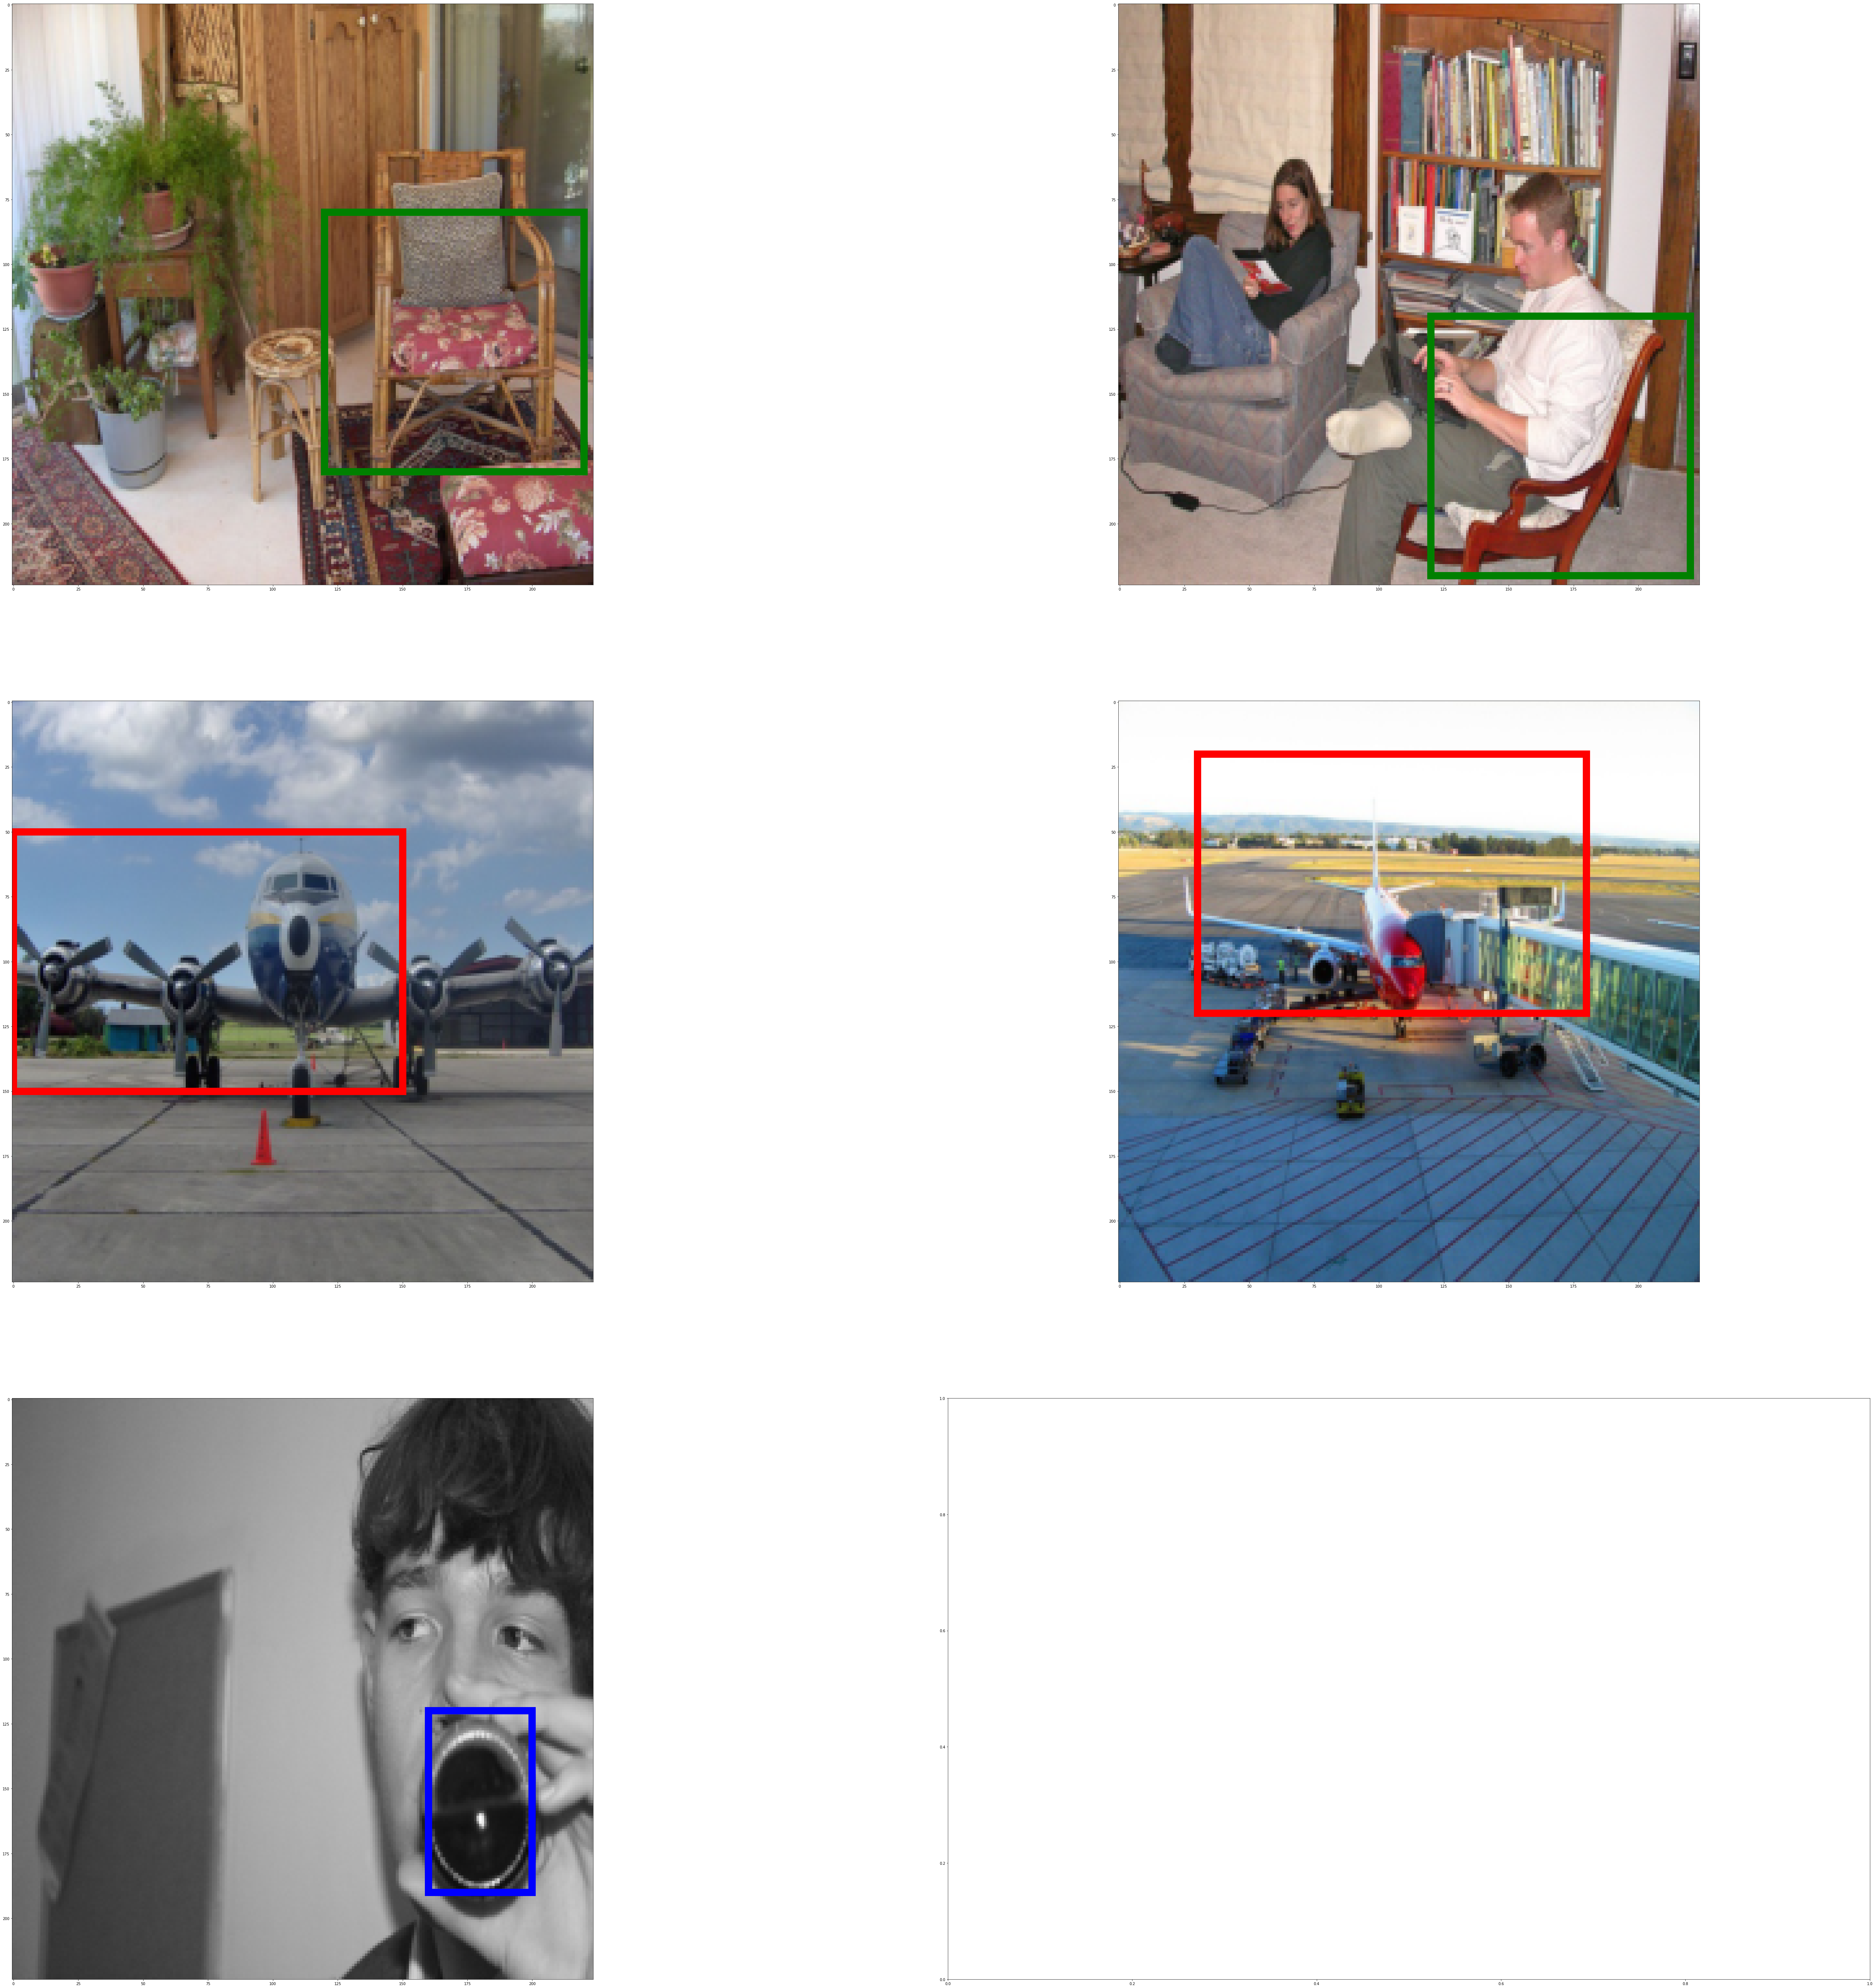

In [116]:
myplot(plot_image, correct1)

## Layer 1 model, incorrect predictions

<font color='red' size=5><b>Red Box : Aeroplane</b></font> &nbsp;&nbsp;
<font color='blue' size=5><b>Blue Box : Bottle</b></font>  &nbsp;&nbsp;
<font color='green' size=5><b>Green Box : Chair</b></font> 

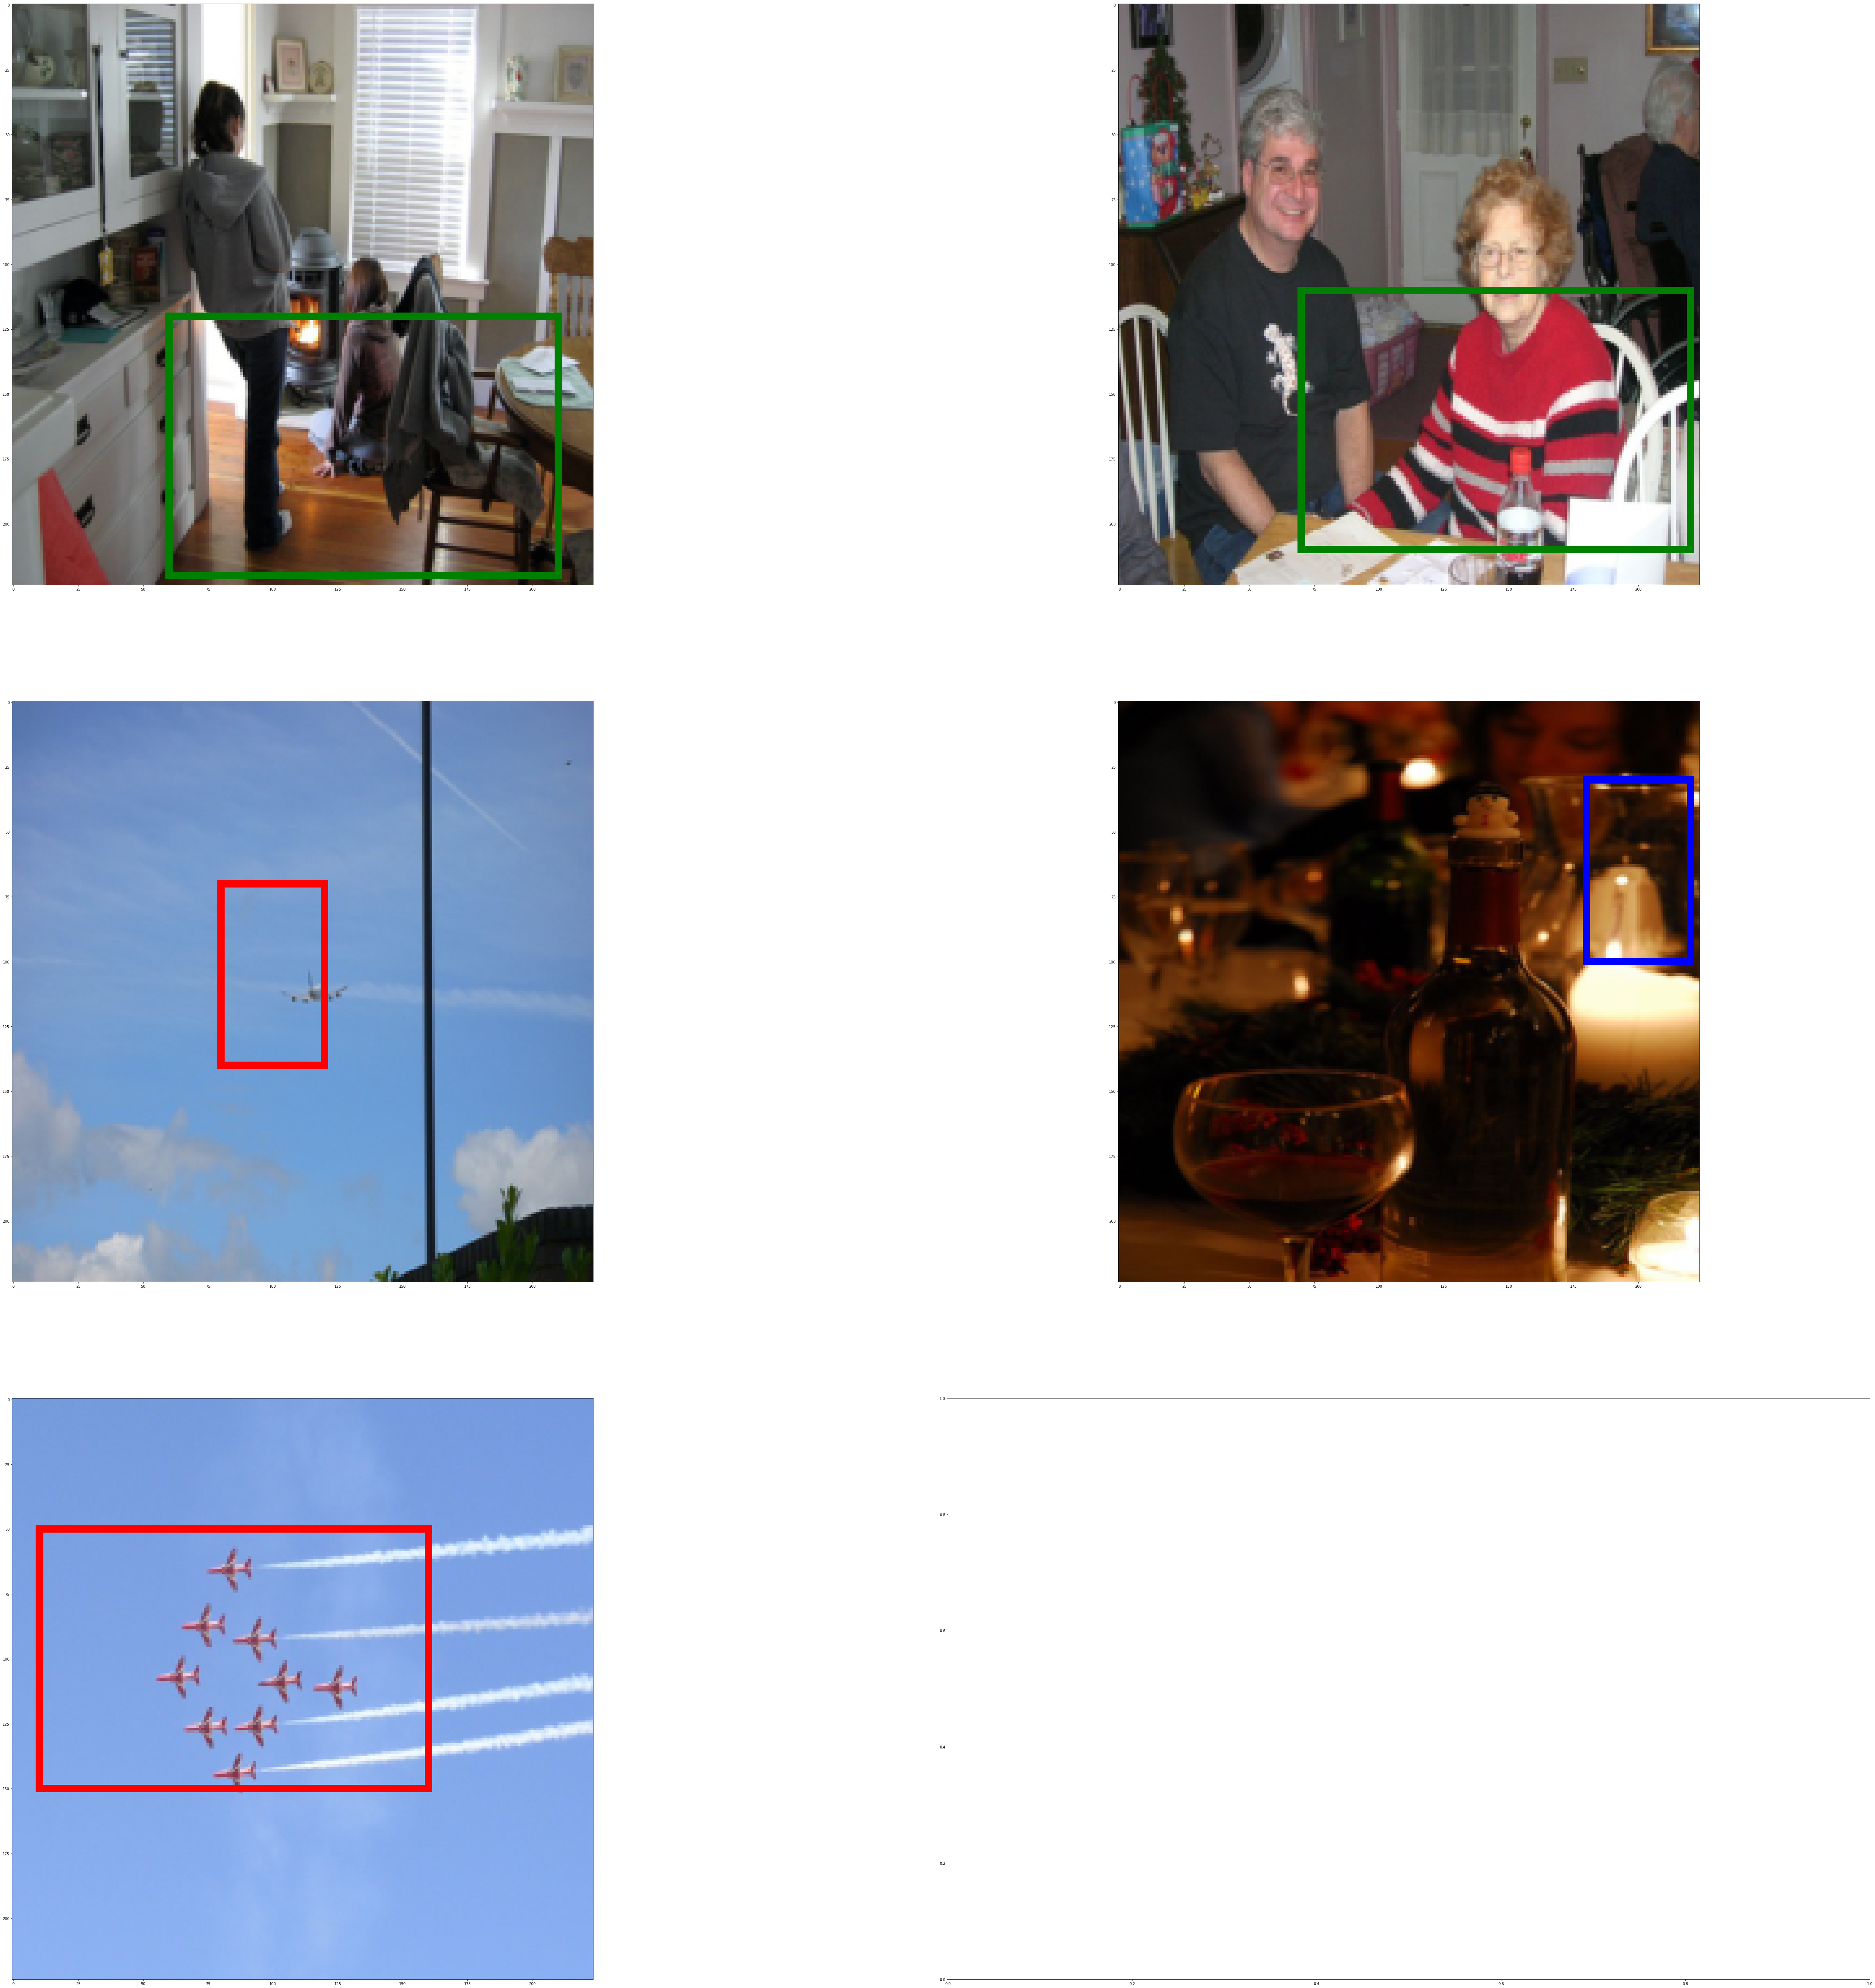

In [117]:
myplot(plot_image, incorrect1)

## Layer 2 model, correct predictions

<font color='red' size=5><b>Red Box : Aeroplane</b></font> &nbsp;&nbsp;
<font color='blue' size=5><b>Blue Box : Bottle</b></font>  &nbsp;&nbsp;
<font color='green' size=5><b>Green Box : Chair</b></font> 

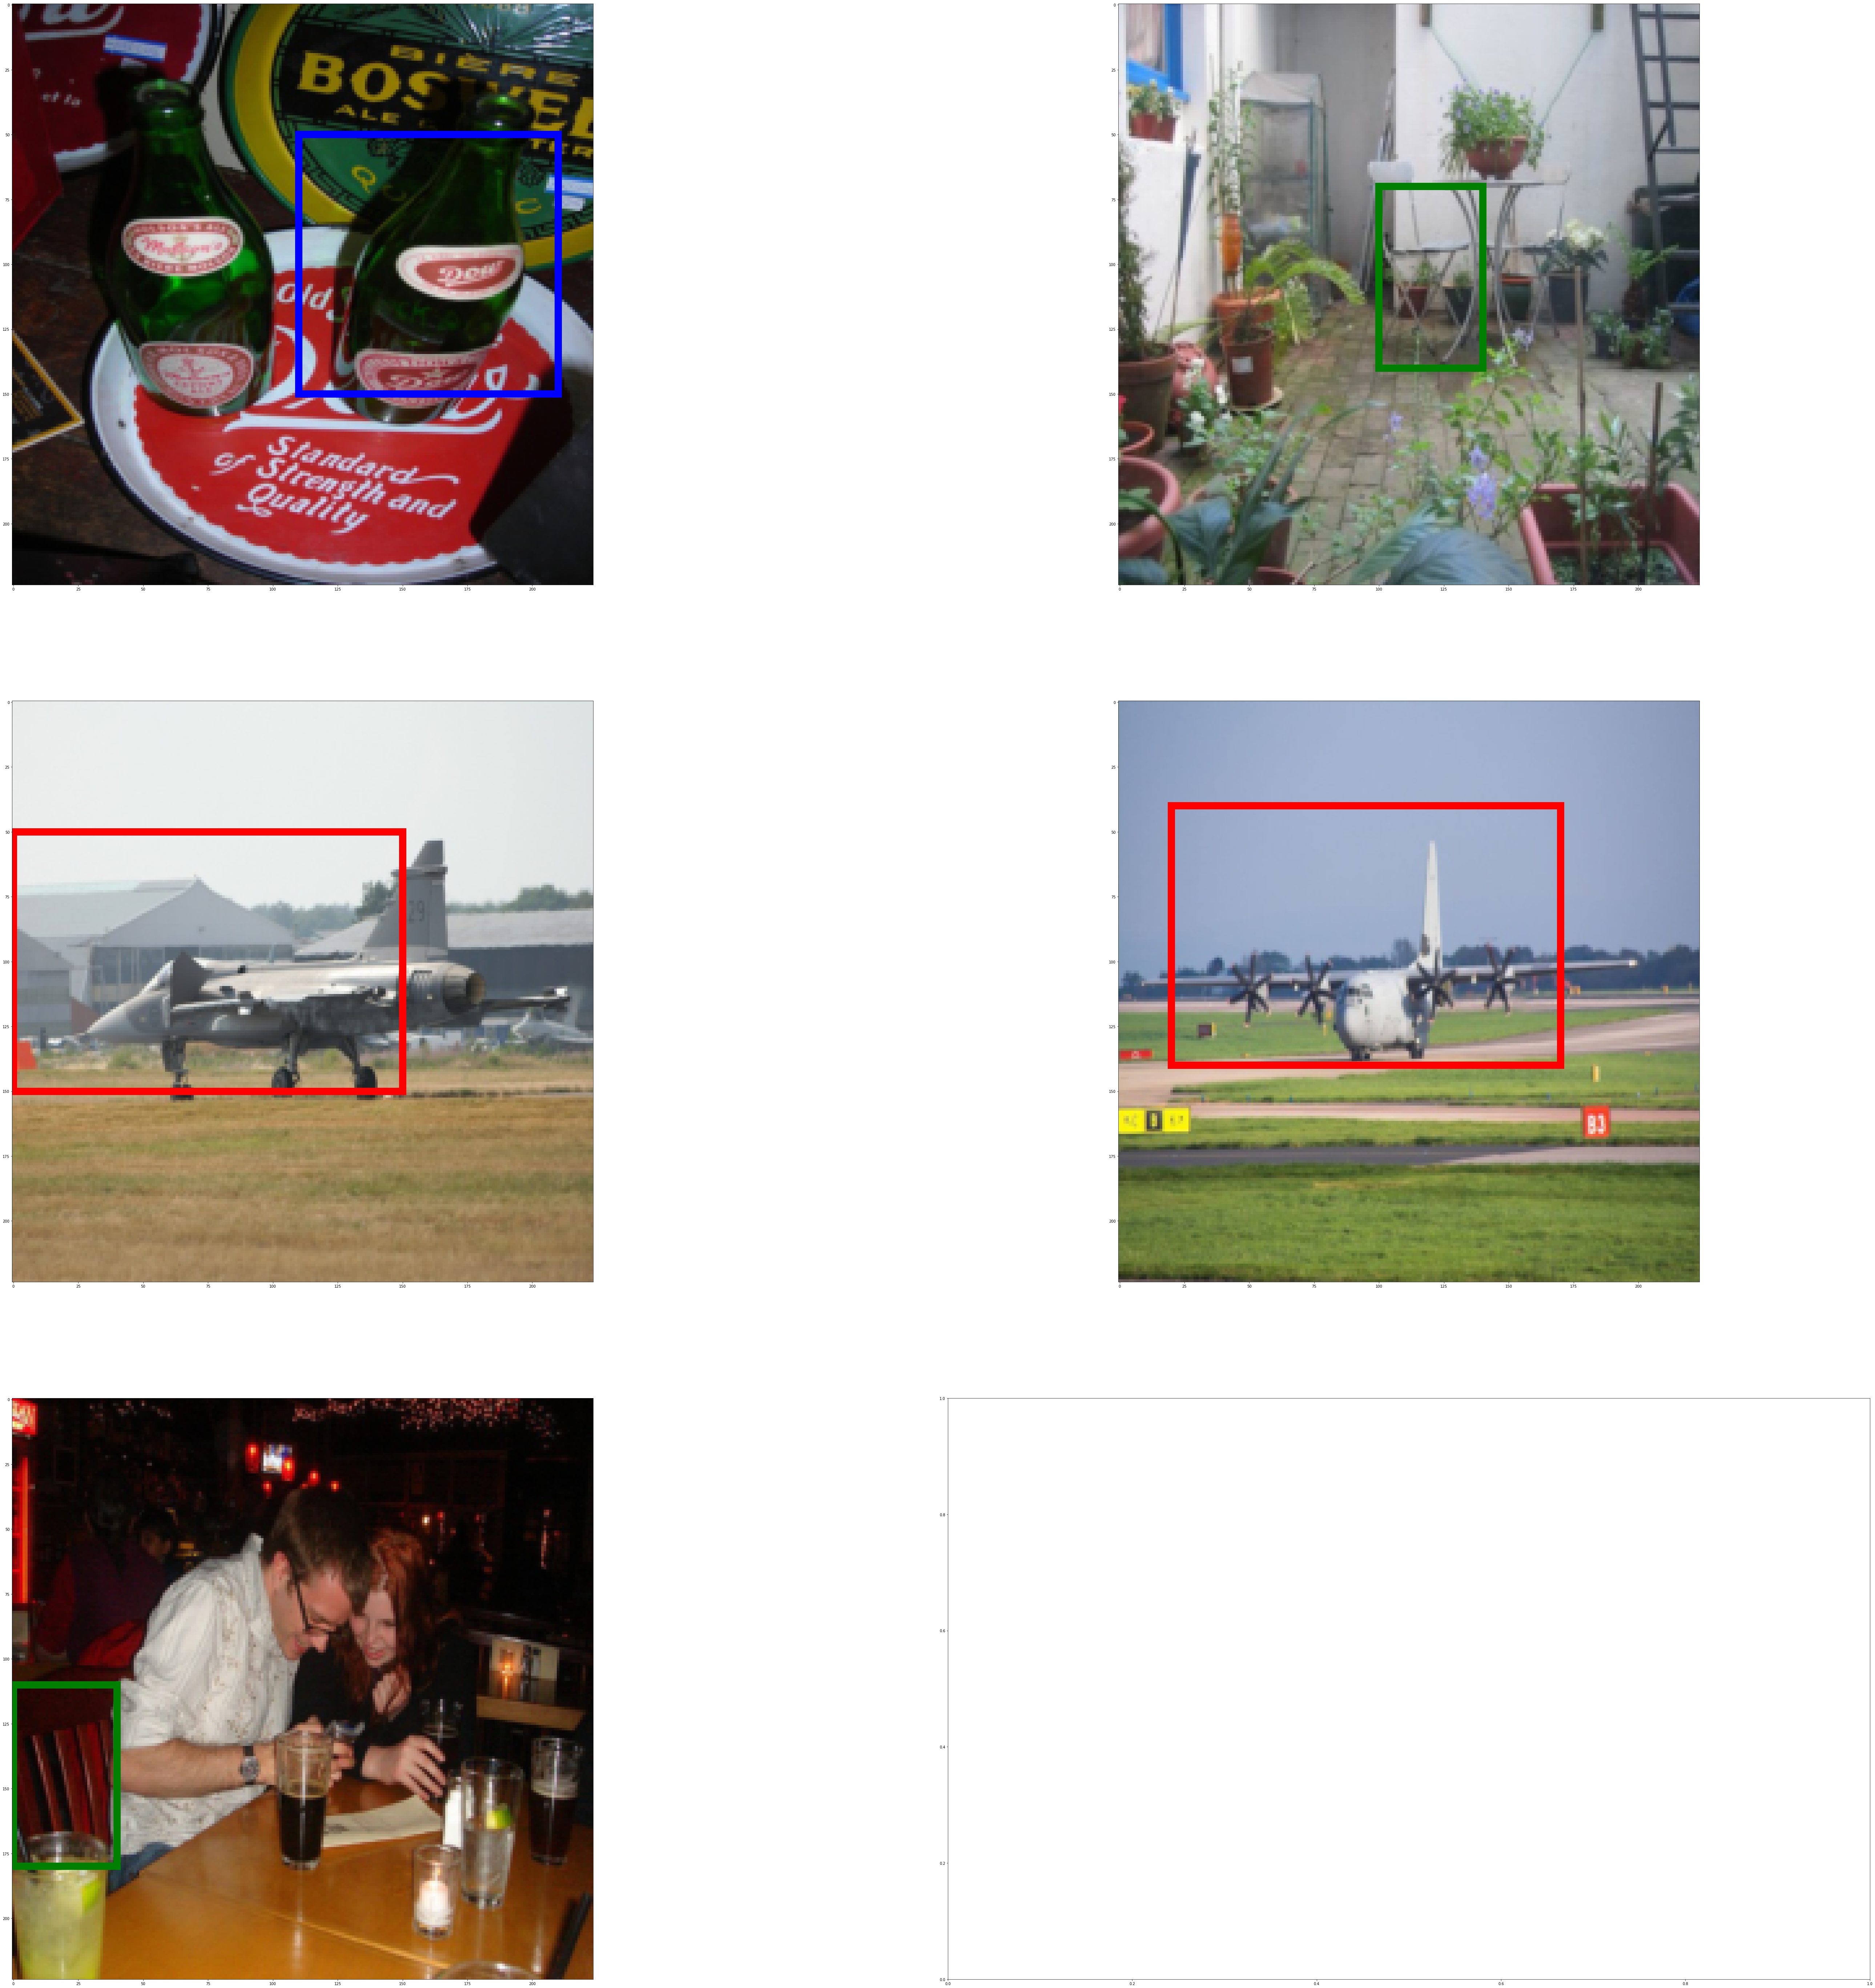

In [113]:
myplot(plot_image, correct2)

## Layer 2 model, incorrect predictions

<font color='red' size=5><b>Red Box : Aeroplane</b></font> &nbsp;&nbsp;
<font color='blue' size=5><b>Blue Box : Bottle</b></font>  &nbsp;&nbsp;
<font color='green' size=5><b>Green Box : Chair</b></font> 

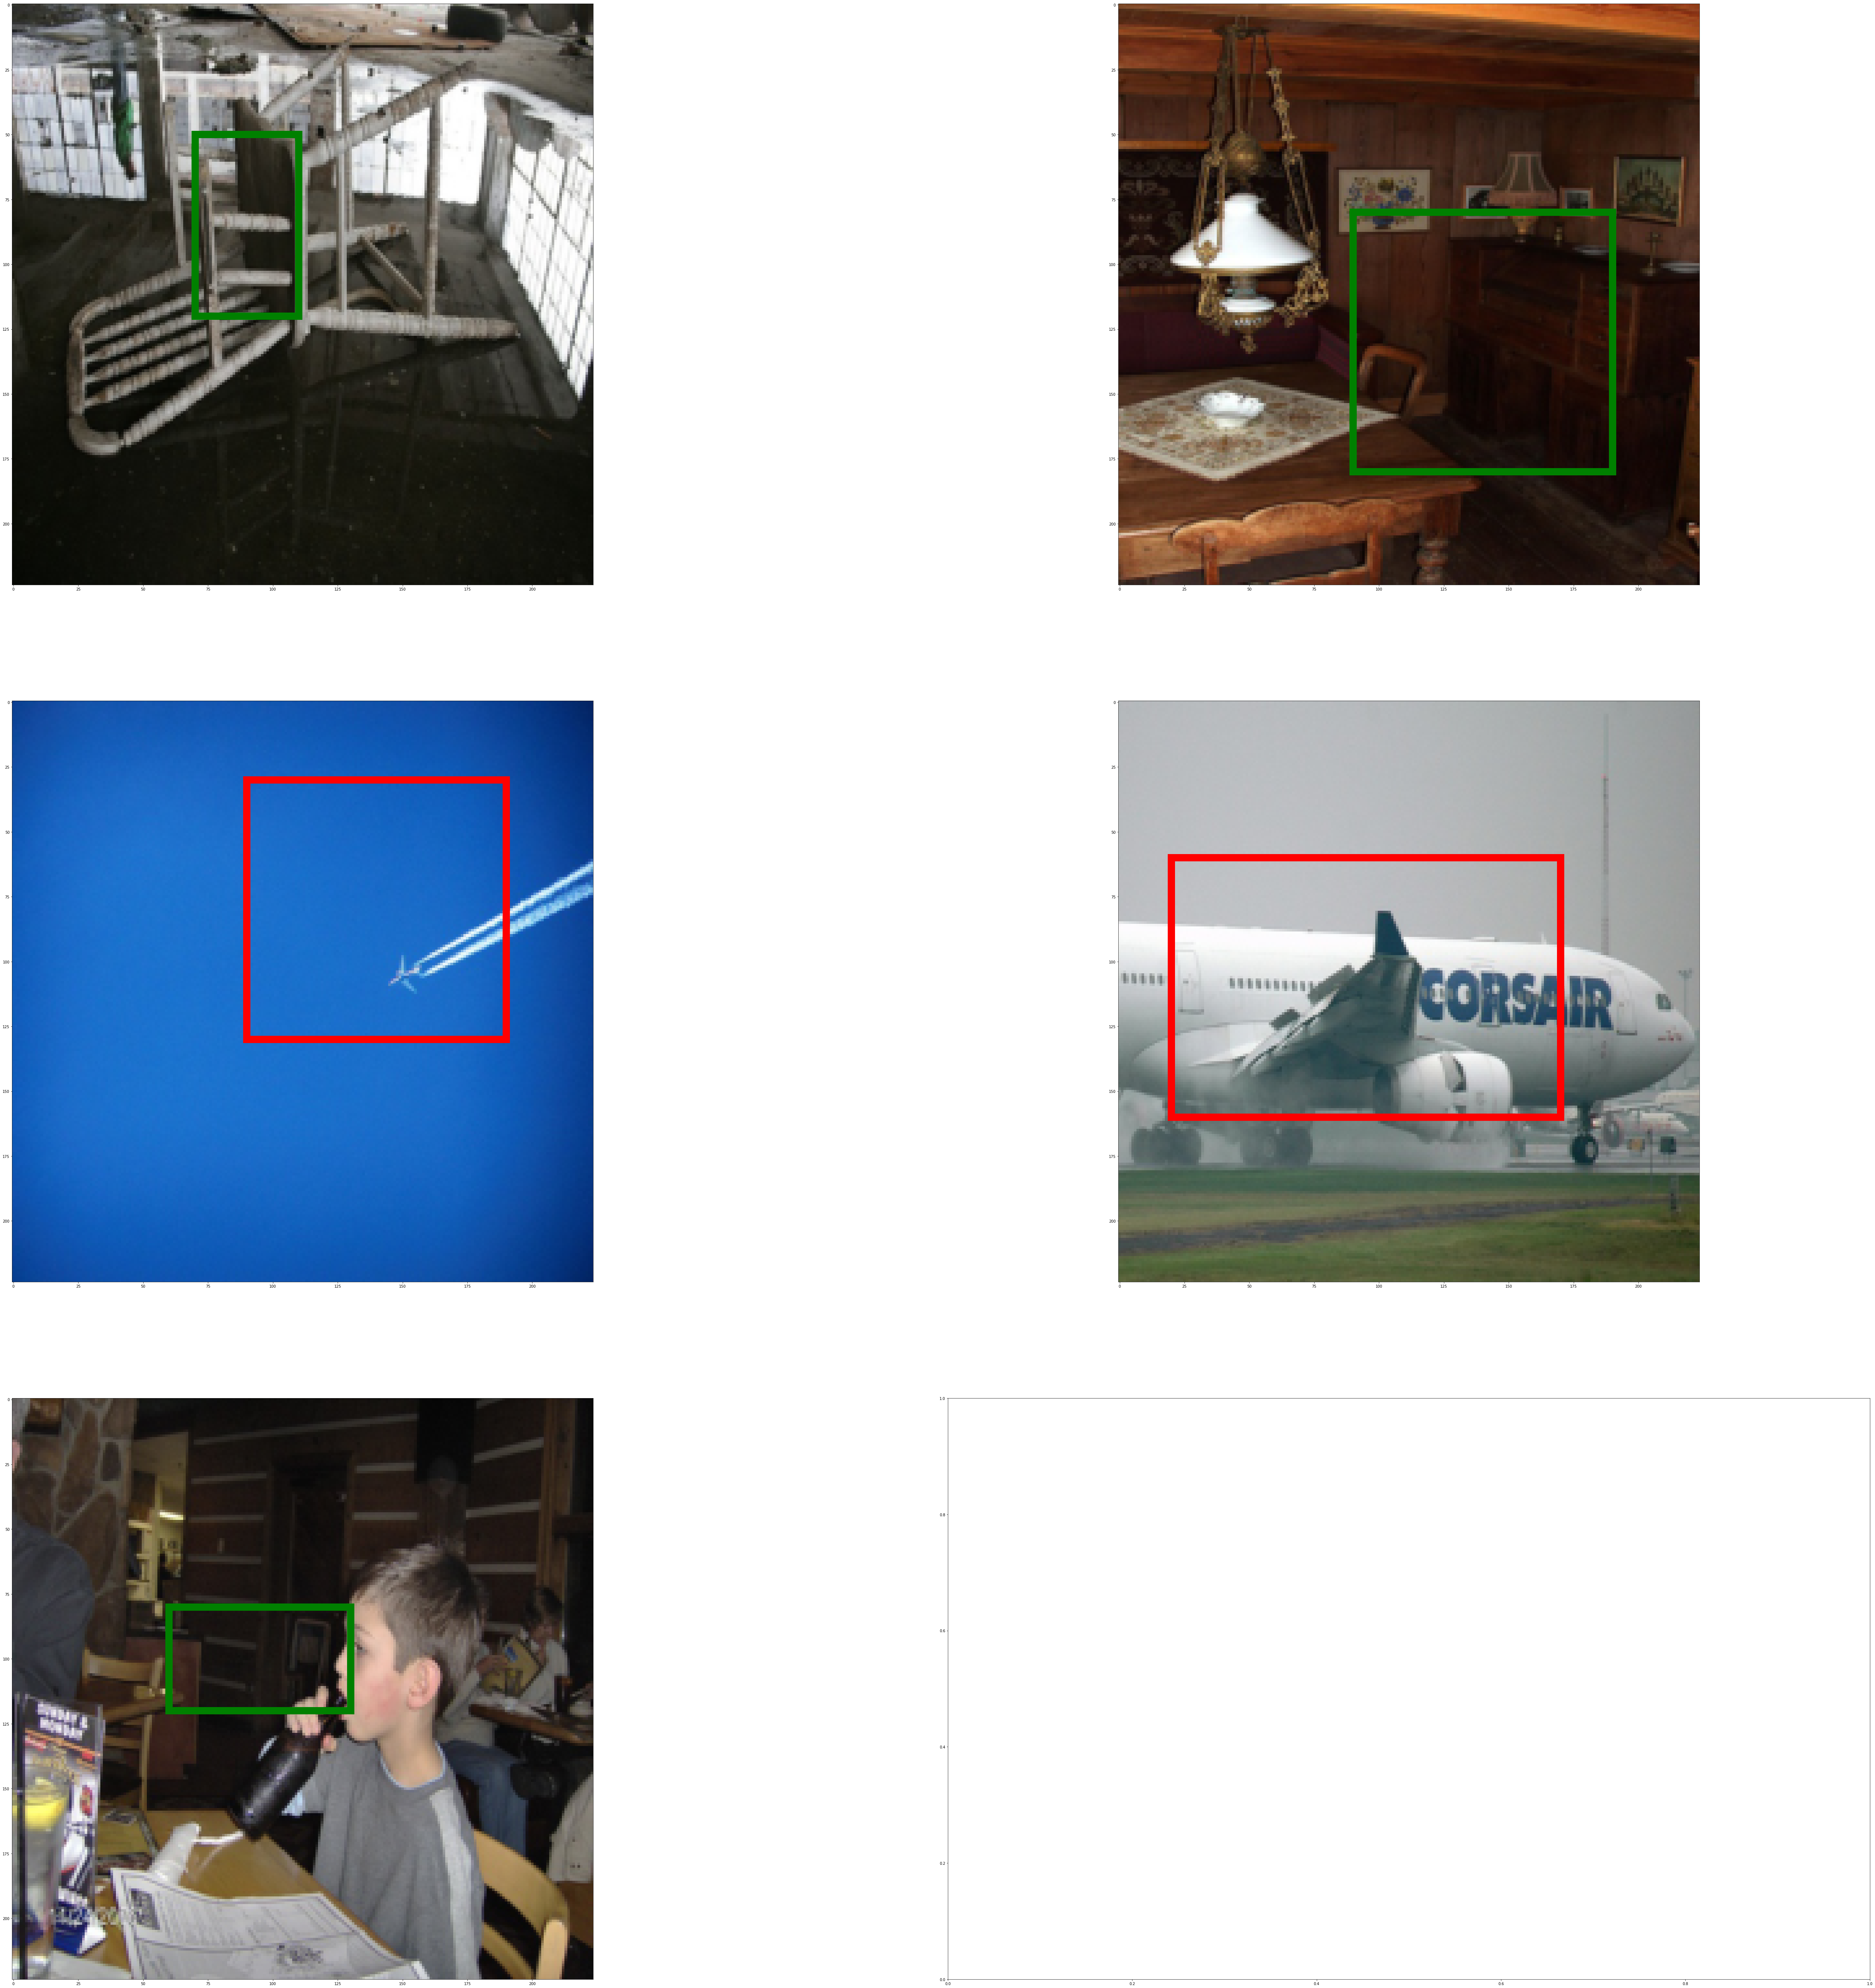

In [114]:
myplot(plot_image, incorrect2)

In [ ]:
predict = {'chair' : ['000234.jpg', '009708.jpg', '007644.jpg', '002189.jpg', '009689.jpg'],
          'aeroplane': ['004078.jpg', '007169.jpg', '007837.jpg', '008016.jpg', '004199.jpg'],
          'bottle' : ['004127.jpg']}

wrong = {'chair' : ['000621.jpg', '002705.jpg', '009595.jpg', '009095.jpg', '005934.jpg'],
        'aeroplane': ['000817.jpg', '000846.jpg', '001505.jpg', '003268.jpg'],
        'bottle' : ['005002.jpg', '006093.jpg']}

In [ ]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.
    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation
    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box, object_boxes)  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision
